In [15]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')
import re
import csv
import os
from matplotlib_venn import venn2
import re
import itertools
from collections import Counter
from fpdf import FPDF

In [16]:
import os
import pandas as pd

base_dir = "joana_type_based/reports"
dfs = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "executionSummary.csv":
            full_path = os.path.join(root, file)
            try:
                df = pd.read_csv(full_path, sep=';', engine='python')

                # Extrair project e merge commit
                rel_path = os.path.relpath(full_path, base_dir)
                parts = rel_path.split(os.sep)
                project = parts[0] if len(parts) > 0 else ''
                merge_commit = parts[1] if len(parts) > 1 else ''

                df['project'] = project
                df['merge commit'] = merge_commit
                df['original method'] = df['Method'] if 'Method' in df.columns else ''
                df['class'] = df['Method'].apply(
                    lambda x: x.split("(")[0].split('.')[:-1][-1].split("$")[0] if isinstance(x, str) else ''
                ) if 'Method' in df.columns else ''

                dfs.append(df)

            except Exception as e:
                print(f"Erro ao processar {full_path}: {e}")

if dfs:
    final_df = pd.concat(dfs, ignore_index=True)

    # Reordenar colunas: coloca as novas no início e mantém o resto
    first_cols = ['project', 'merge commit', 'class', 'original method']
    other_cols = [col for col in final_df.columns if col not in first_cols]
    final_df = final_df[first_cols + other_cols]

    final_df.to_csv("merged_file.csv", index=False, sep=';')
    print("Arquivo merge_results.csv gerado com sucesso com todas as colunas.")
else:
    print("Nenhum arquivo executionSummary.csv encontrado.")


Arquivo merge_results.csv gerado com sucesso com todas as colunas.


### Entradas

* LOI.csv
* merged_file.csv (resultado do SDG)
* revList.csv (do SDG)
* soot-results.csv (resultado do Static Analysis)

Reading analyses execution results...
Generating results...
 Yes  Yes
boolean org.elasticsearch.river.mongodb.Slurper.assignCollections()
 No  No
MongoDBRiverDefinition org.elasticsearch.river.mongodb.MongoDBRiverDefinition.parseSettings(String, String, RiverSettings, ScriptService)
 No  No
void org.elasticsearch.river.mongodb.Slurper.run()
 Yes  No
org.elasticsearch.river.mongodb.MongoDBRiverDefinition org.elasticsearch.river.mongodb.MongoDBRiverDefinition.parseSettings(java.lang.String, java.lang.String, org.elasticsearch.river.RiverSettings, org.elasticsearch.script.ScriptService)
 No  Yes
void cuke4duke.internal.java.JavaLanguage.load(String)
 No  No
void com.relayrides.pushy.apns.PushManager.handleConnectionClosure(com.relayrides.pushy.apns.ApnsConnection)
 No  Yes
boolean org.opentripplanner.routing.spt.MultiShortestPathTree.dominates(State, State)
 Yes  Yes
void com.zaxxer.hikari.HikariPool.addConnection()
No No
void com.zaxxer.hikari.HikariConfig.validate()
 No  No
Lwjgl3Applic

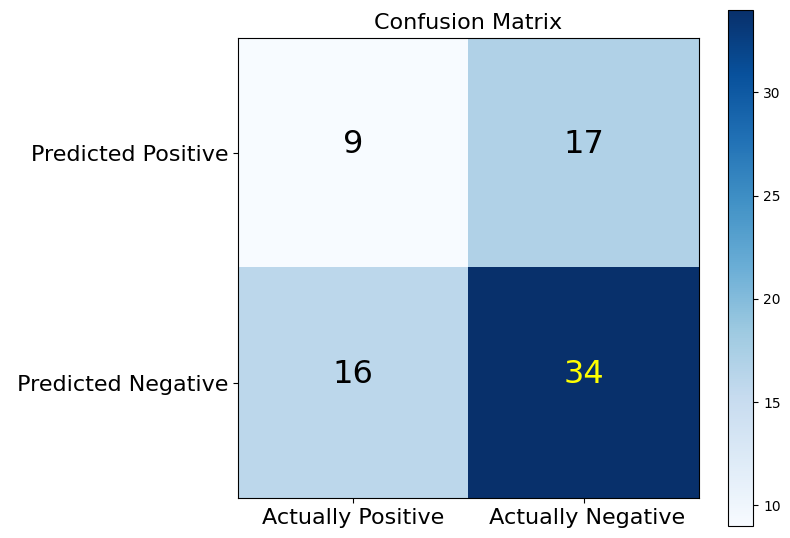

In [17]:
class ReportAnalysis:

    def __init__(self, path_result, path_ground_truth):
        self.soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
        self.loi = pd.read_csv(path_ground_truth, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

        self.generate_results()

    def get_method_name(self, method_declaration):
        match = re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\(', method_declaration)
        if match:
            method_name = match.group(1)
            print("Method name:", method_name)
        else:
            print("Method name not found.")

    def get_loi(self, project, class_name, method, merge_commit):
        df = pd.read_csv("LOI.csv", delimiter=';')
        print(method)
        dot_index = method.rfind('.')
        paren_index = method.find('(')

        method_name = ""

        if dot_index != -1 and paren_index != -1:
            method_name = method[dot_index + 1:paren_index]

        value_LOI = ("", "")
        
        for project_l, class_name_l, method_l, merge_commit_l, LOI, original_sample in zip(
            df['Project'], 
            df['Class Name'], 
            df['Method or field declaration changed by the two merged branches'], 
            df['Merge Commit'], 
            df['Locally Observable Interference'],
            df['Original Sample'],
        ):
            if (project_l == project and 
                class_name in class_name_l  and 
                method_name in method_l and 
                merge_commit_l == merge_commit):
                
                value_LOI = (LOI, original_sample)

                break 
        return value_LOI

    def calculate_matrix_loi(self, columns):
        results = []
        loi_list = []
        original_sample_list = []
        info_LOI = ['project', 'class', 'original method', 'merge commit']
        
        self.soot_results.columns = self.soot_results.columns.str.strip()
        
        for index, row in self.soot_results.iterrows():
            value1 = "No" if "-" in str(row['HasLeftToRightVio']) else row['HasLeftToRightVio']
            value2 = "No" if "-" in str(row['HasRightToLeftVio']) else row['HasRightToLeftVio']
            sdg_created = row['SdgCreated']
            
            print(value1, value2)
            values_LOI = [row[column] for column in info_LOI if column in row]
            (loi_actual, original_sample) = self.get_loi(*values_LOI)
            
            loi_list.append(loi_actual)
            original_sample_list.append(original_sample)

            result = "-"
            if "Yes" in str(sdg_created):
                if ( "Yes" in str(value1) or "Yes" in str(value2) ) and "Yes" in loi_actual:
                    result = "TRUE POSITIVE"
                elif ( "No" in str(value1) and "No" in str(value2) ) and "No" in loi_actual:
                    result = "TRUE NEGATIVE"
                elif ( "No" in str(value1) and "No" in str(value2) ) and "Yes" in loi_actual:
                    result = "FALSE NEGATIVE"
                elif ("Yes" in str(value1) or "Yes" in str(value2) ) and "No" in loi_actual:
                    result = "FALSE POSITIVE"
            
            results.append(result)
            
        df = pd.read_csv('merged_file.csv', sep=';')
        df['LOI'] = loi_list
        df['Original Sample'] = original_sample_list
        df['result'] = results

        new_csv_path = 'output/results_sdg.csv'
        df.to_csv(new_csv_path, sep=';', index=False)

        return results

    def generate_results(self):

        print("Generating results...")

        FP,TP, FN, TN = 0, 0, 0, 0

        list_columns = self.soot_results.columns.tolist()

        result_matrix = self.calculate_matrix_loi(list_columns)

        for elem, count in Counter(result_matrix).items():
            if (elem == 'FALSE POSITIVE'):
                FP = count
            if (elem == 'FALSE NEGATIVE'):
                FN = count
            if (elem == 'TRUE POSITIVE'):
                TP = count
            if (elem == 'TRUE NEGATIVE'):
                TN = count

        sensitivity = 0 if ((TP + FN) == 0) else (TP / (TP + FN))
        precision = 0 if ((TP + FP) == 0) else (TP / (TP + FP))
        f1_score = 0 if ((2*TP + FP + FN) == 0) else (2*TP / (2*TP + FP + FN))
        accuracy = 0 if ((FP + TP + TN + FN) == 0) else ((TP + TN) / (FP + TP + TN + FN))

        df = pd.read_csv("output/results_sdg.csv", sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
       
        fail_results = df['result'].eq("-").sum()
        total = len(df)

        # variable pdf
        pdf = FPDF()

        # add a page
        pdf.add_page()

        # set style and size of font
        # that you want in the pdf
        pdf.set_font("Arial", size = 15)

        # create a cell
        pdf.cell(200, 10, txt = "Results for execution",
                 ln = 1, align = 'C')
    
        pdf.cell(200, 10, txt = ("Precision: "+str(round(precision, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Recall: "+str(round(sensitivity, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("F1 Score: "+str(round(f1_score, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Accuracy: "+str(round(accuracy, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Positives: "+str(FP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Negatives: "+str(FN)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Positives: "+str(TP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Negatives: "+str(TN)),
                 ln = 2, align = 'L')
        
        pdf.cell(200, 10, txt = (f"Total produzed: {total-fail_results} out of {total} units"),
                 ln = 2, align = 'L')

        cm = np.array([[TP,  FP], [FN, TN]])
        normalize = False
        target_names = ['Actually Positive', ' Actually Negative']
        target_names2 = ['Predicted Positive', ' Predicted Negative']
        title = "Confusion Matrix"

        cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, fontsize=16)
            plt.yticks(tick_marks, target_names2, fontsize=16)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
        plt.tight_layout()

        plt.savefig("output/confusion_matrix.jpg")

        pdf.image("output/confusion_matrix.jpg", x = None, y = None, w = 160, h = 110, type = 'jpg', link = 'output/confusion_matrix.jpg')

        # Save the pdf with name .pdf
        pdf.output("output/results_sdg.pdf")
        
        print("Results in output/results_sdg.pdf")

os.makedirs('output', exist_ok=True)
path_ground_truth = "LOI.csv"
path_result = 'merged_file.csv'

print("Reading analyses execution results...")

ReportAnalysis(path_result, path_ground_truth)

#project, class_name, method, merge_commit
#Colunas:  ['druid', 'S3SegmentPusher', '05168808c278c080c59c19e858d9471b316cd1f5']



In [18]:

path_result = 'output/results_sdg.csv'

print("Reading analyses execution results...")
soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

soot_results.columns = soot_results.columns.str.strip()
list_time_seconds = []

for index, row in soot_results.iterrows():
    value = row['Time (ms)']
    try:
        if str(value) not in ['', '-', 'NaN', 'nan']:
            list_time_seconds.append(float(value) / 1000)
    except ValueError:
        continue
       
print(list_time_seconds)


Reading analyses execution results...
[8823.91, 16696.766, 20937.879, 16331.725, 94.559, 50794.522, 97.934, 101.629, 122.389, 92.45, 138.15, 8676.247, 154.191, 101.401, 104.383, 104.383, 126.953, 93.032, 95.702, 125.64, 101.128, 102.481, 251.692, 215.539, 238.927, 243.261, 103.984, 113.818, 113.818, 39218.595, 32175.947, 27868.365, 10007.907, 22417.816, 237.426, 95.055, 233.021, 97.675, 2027.467, 570.779, 4508.337, 747.37, 584.502, 126.585, 106.706, 95.126, 164.481, 4256.232, 4256.232, 16329.205, 358.27, 367.852, 339.501, 19544.368, 44236.675, 73026.805, 46318.14, 9669.458, 101.572, 99.965, 99.965, 99.965, 17821.502, 98.248, 28409.052, 24730.824, 26614.199, 243.058, 121.758, 40418.11, 128.466, 100.974, 1146.909, 100.857, 95.034, 1146.079]


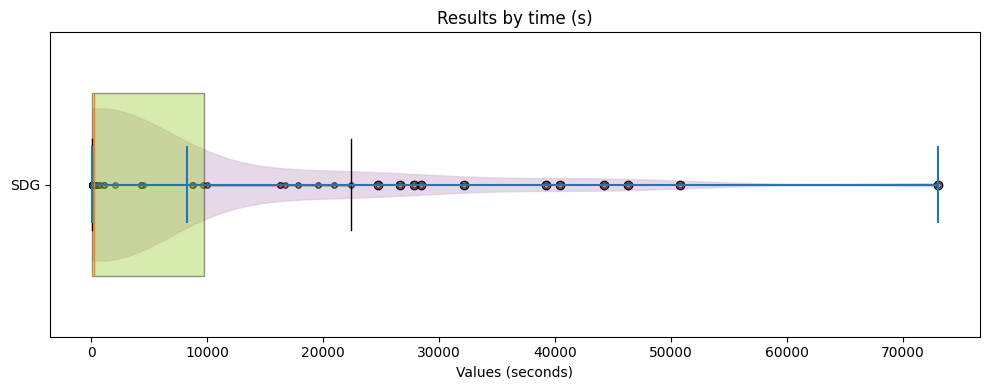

In [19]:
class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg_x, time_list1):
        fig, ax = plt.subplots(figsize=(10, 4))

        data_x = [time_list1]

        boxplot_color = 'yellowgreen'
        violin_color = 'thistle'
        scatter_color = 'tomato'

        # Boxplot
        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1], widths=0.6)
        for patch in bp['boxes']:
            patch.set_facecolor(boxplot_color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for b in vp['bodies']:
            b.set_color(violin_color)
            b.set_alpha(0.6)

        # Scatterplot
        features = data_x[0]
        y = np.full(len(features), 1)
        jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
        ax.scatter(features + jitter, y, s=15, c=scatter_color, alpha=0.7, edgecolor='k')

        ax.set_yticks([1])
        ax.grid(False)
        ax.set_yticklabels([leg1])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        plt.tight_layout()
        plt.savefig("output/rain_cloud_time_sdg.jpg", dpi=300)
        plt.show()

    
plotter = Plotter()

y = "SDG"
x = "Values (seconds)"

plotter.plot_by_variable(y, x, list_time_seconds)

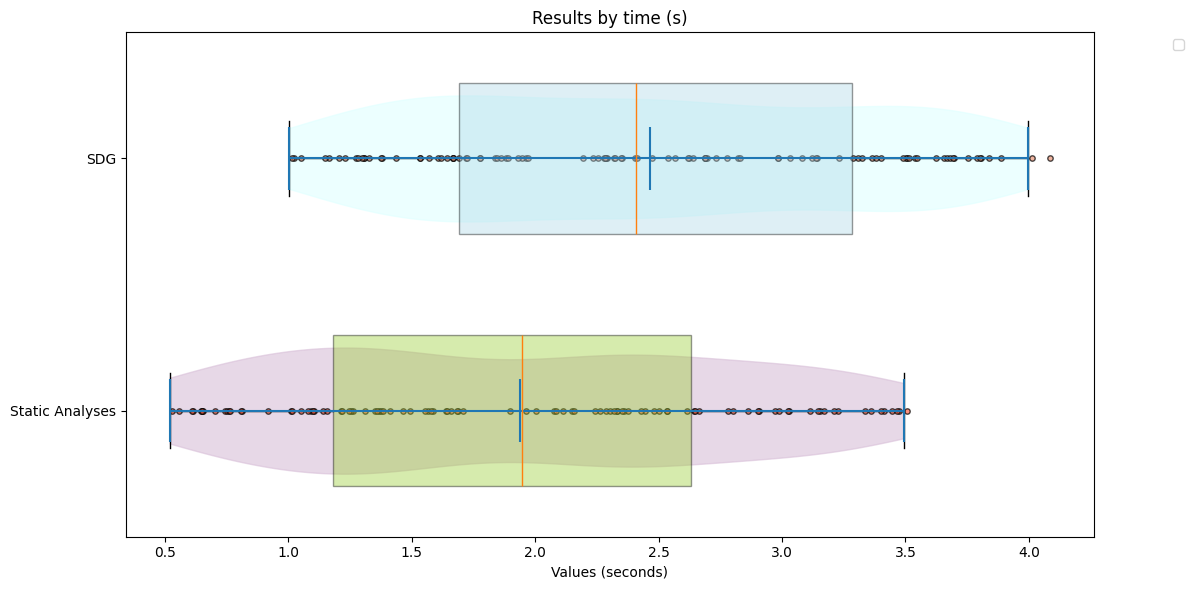

In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg2, leg_x, time_list1, time_list2):
        fig, ax = plt.subplots(figsize=(12, 6))

        data_x = [time_list1, time_list2]

        boxplots_colors = ['yellowgreen', 'lightblue']
        violin_colors = ['thistle', 'lightcyan']
        scatter_colors = ['tomato', 'darksalmon']

        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1, 2], widths=0.6)
        for patch, color in zip(bp['boxes'], boxplots_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for idx, b in enumerate(vp['bodies']):
            b.set_color(violin_colors[idx])
            b.set_alpha(0.6)

        # Scatterplot
        for idx, features in enumerate(data_x):
            y = np.full(len(features), idx + 1)
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
            ax.scatter(features + jitter, y, s=15, c=scatter_colors[idx], alpha=0.7, edgecolor='k')

        # configuration
        ax.set_yticks([1, 2])
        ax.grid(False)
        ax.set_yticklabels([leg1, leg2])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
        plt.tight_layout()
        plt.savefig("output/rain_cloud_time_sdg_sam.jpg", dpi=300)
        plt.show()

       
plotter = Plotter()

random.seed(42)  # Para reprodutibilidade
time_list1 = [random.uniform(0.5, 3.5) for _ in range(100)]
time_list2 = [random.uniform(1.0, 4.0) for _ in range(100)]

variable = "Execution Time"

plotter.plot_by_variable("Static Analyses", "SDG", "Values (seconds)", time_list1, time_list2)


Reading analyses execution results...
Reading analyses execution results...
Generating results...
Results in output/results_sa.pdf


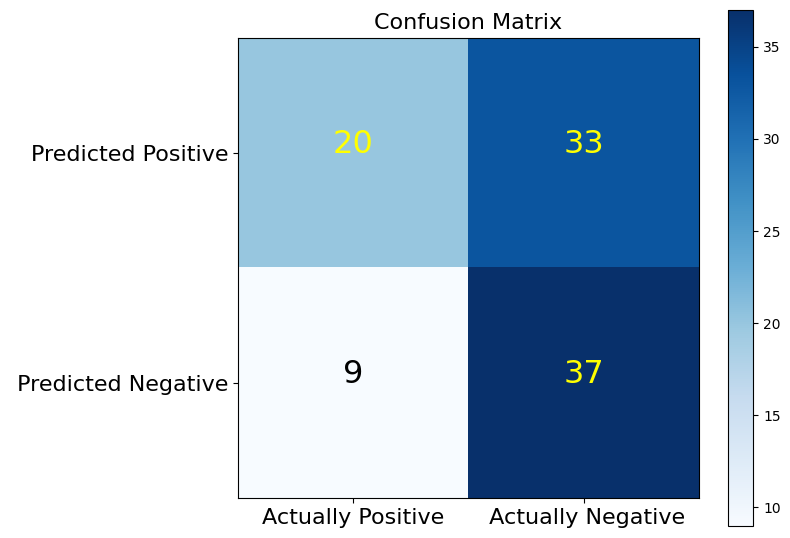

In [21]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from matplotlib import pyplot as plt
from fpdf import FPDF

class ReportAnalysis:

    def __init__(self, path_result, path_ground_truth):
        self.soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
        self.loi = pd.read_csv(path_ground_truth, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

        self.generate_results()

    def get_loi(self, project, class_name,  method, merge_commit):

        filter_scenario = (self.loi['Project'] == str(project)) & (self.loi['Merge Commit'] == str(merge_commit)) & (self.loi['Class Name'] == str(class_name)) & (self.loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = self.loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

    def calculate_matrix_loi(self, columns):
        results = []
        loi_list = []
        info_LOI = ['project', 'class', 'method', 'merge commit']

        for index, row in self.soot_results.iterrows():
            list_values = self.soot_results.columns.tolist()
            remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
            list_values = [coluna for coluna in list_values if coluna not in remove_columns]
            values = [row[column] for column in list_values]

            values_LOI = [row[column] for column in info_LOI]

            loi_actual = self.get_loi(*values_LOI)
            loi_list.append(loi_actual)
            or_value = any(str(value).lower() != 'false' for value in values)

            result = ""
            if or_value == True and loi_actual == 'Yes':
                result = "TRUE POSITIVE"
            elif or_value == False and loi_actual == 'No':
                result = "TRUE NEGATIVE"
            elif or_value == False and loi_actual == 'Yes':
                result = "FALSE NEGATIVE"
            elif or_value == True and loi_actual == 'No':
                result = "FALSE POSITIVE"
            results.append(result)


        self.soot_results['LOI'] = loi_list
        self.soot_results['result'] = results

        self.soot_results.to_csv('output/result_static.csv', sep=';', index=False)

        return results
            
    def generate_results(self):

        print("Generating results...")

        FP,TP, FN, TN = 0, 0, 0, 0

        list_columns = self.soot_results.columns.tolist()

        result_matrix = self.calculate_matrix_loi(list_columns)

        for elem, count in Counter(result_matrix).items():
            if (elem == 'FALSE POSITIVE'):
                FP = count
            if (elem == 'FALSE NEGATIVE'):
                FN = count
            if (elem == 'TRUE POSITIVE'):
                TP = count
            if (elem == 'TRUE NEGATIVE'):
                TN = count

        sensitivity = 0 if ((TP + FN) == 0) else (TP / (TP + FN))
        precision = 0 if ((TP + FP) == 0) else (TP / (TP + FP))
        f1_score = 0 if ((2*TP + FP + FN) == 0) else (2*TP / (2*TP + FP + FN))
        accuracy = 0 if ((FP + TP + TN + FN) == 0) else ((TP + TN) / (FP + TP + TN + FN))

        # variable pdf
        pdf = FPDF()

        # add a page
        pdf.add_page()

        # set style and size of font
        # that you want in the pdf
        pdf.set_font("Arial", size = 15)

        # create a cell
        pdf.cell(200, 10, txt = "Results for execution",
                 ln = 1, align = 'C')

        pdf.cell(200, 10, txt = ("Precision: "+str(round(precision, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Recall: "+str(round(sensitivity, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("F1 Score: "+str(round(f1_score, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Accuracy: "+str(round(accuracy, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Positives: "+str(FP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Negatives: "+str(FN)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Positives: "+str(TP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Negatives: "+str(TN)),
                 ln = 2, align = 'L')

        cm = np.array([[TP,  FP], [FN, TN]])
        normalize = False
        target_names = ['Actually Positive', ' Actually Negative']
        target_names2 = ['Predicted Positive', ' Predicted Negative']
        title = "Confusion Matrix"

        cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, fontsize=16)
            plt.yticks(tick_marks, target_names2, fontsize=16)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
        plt.tight_layout()

        plt.savefig("output/confusion_matrix.jpg")

        pdf.image("output/confusion_matrix.jpg", x = None, y = None, w = 160, h = 110, type = 'jpg', link = 'output/confusion_matrix.jpg')

        # Save the pdf with name .pdf
        pdf.output("output/results_sa.pdf")
    
        print("Results in output/results_sa.pdf")


print("Reading analyses execution results...")

path_ground_truth = "LOI.csv"
path_result = 'soot-results.csv'
list_calculate = ['Confluence Inter', 'OA Inter', 'left right DFP-Inter', 'right left DFP-Inter', 'left right PDG', 'right left PDG']
print("Reading analyses execution results...")

ReportAnalysis(path_result, path_ground_truth)



In [22]:
df1 = pd.read_csv("output/results_sdg.csv", sep=";")

df1["method"] = df1["original method"].apply(
    lambda x: re.search(r"\.([a-zA-Z0-9_]+)\(", x.strip()).group(1) 
    if isinstance(x, str) and re.search(r"\.([a-zA-Z0-9_]+)\(", x.strip()) else ""
)

method_column = df1.pop("method")  # Remover a coluna 'method'
df1.insert(df1.columns.get_loc("original method"), "method", method_column)

df1 = df1.drop(columns=["original method"])

df1.to_csv("output/df_sdg.csv", sep=";", index=False)

In [23]:
df1 = pd.read_csv("output/result_static.csv", sep=";")

df1["method"] = df1["method"].apply(
    lambda x: re.match(r"([a-zA-Z0-9_]+)", x).group(1) if isinstance(x, str) else ""
)

df1["class"] = df1["class"].apply(
    lambda x: x.split('.')[-1] if isinstance(x, str) else ""
)

df1.to_csv("output/df_static.csv", sep=";", index=False)


TRUE POSITIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
FALSE POSITIVE
TRUE NEGATIVE
TRUE POSITIVE
TRUE POSITIVE
FALSE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE POSITIVE
FALSE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE NEGATIVE
FALSE NEGATIVE
FALSE NEGATIVE
FALSE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
FALSE POSITIVE
TRUE NEGATIVE
FALSE POSITIVE
FALSE POSITIVE
FALSE POSITIVE
FALSE POSITIVE
TRUE NEGATIVE
FALSE NEGATIVE
TRUE POSITIVE
FALSE POSITIVE
TRUE NEGATIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
TRUE NEGATIVE
FALSE POSITIVE
TRUE NEGATIVE
FALSE POSITIVE
FALSE NEGATIVE
TRUE NEGATIVE
FALSE POSITIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
FALSE POSITIVE
FALSE POSITIVE
FALSE POSITIVE
FALSE POSITIVE
FALSE NEGATIVE
FALSE POSITIVE
FALSE POSITIVE
TRUE POSITIVE
TRUE POSITIVE
FALSE POSITIVE
TRUE POSITIVE
FALSE POSITIVE
TRUE NEGATIVE
TRUE NEGATIVE
TRUE NEGATIVE
FALSE NEGATIVE
TRUE NE

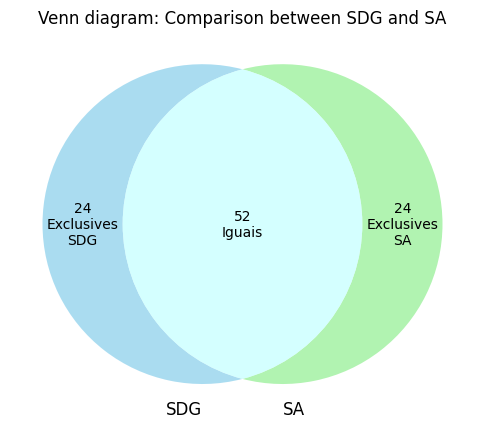

In [24]:
def get_result_from_df(df, project, merge_commit, class_name, method_name):    
    matching_row = df[
        (df["project"].str.contains(project, na=False)) &
        (df["merge commit"].str.contains(merge_commit, na=False)) &
        (df["class"].str.contains(class_name, na=False)) &
        (df["method"].str.contains(method_name, na=False))
    ]
    
    return matching_row["result"].iloc[0] if not matching_row.empty else None

df1 = pd.read_csv("output/df_sdg.csv", sep=";")
df2 = pd.read_csv("output/df_static.csv", sep=";")

resultados = []

sdg_exclusivos = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}
sa_exclusivos = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

sdg_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}
sa_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

equals_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

for _, row in df1.iterrows():
    project = row["project"]
    merge_commit = row["merge commit"]
    class_name = row["class"]
    method_name = row["method"]
    result_sdg = row["result"]
    sdg_create = row[" SdgCreated"]
    hasSourceSink = row[" HasSourcedAndSink"]
    deatailVios = row[" DetailedLineVios"]
    left = row[" Left"]
    right = row[" Right"]
    loi_sdg = row["LOI"]
    sample = row["Original Sample"]


    if result_sdg != "-":  # ignore rows with "-"
        result_sa = get_result_from_df(df2, project, merge_commit, class_name, method_name)
        print(result_sa)
        is_equal = result_sdg == result_sa
        resultados.append((project, merge_commit, class_name, method_name, result_sdg, result_sa, is_equal, sdg_create, hasSourceSink, deatailVios, left, right, loi_sdg, sample))

        if result_sdg in sdg_counts:
            sdg_counts[result_sdg] += 1
        if result_sa in sa_counts:
            sa_counts[result_sa] += 1

        if result_sdg != result_sa:
            if result_sdg in sdg_exclusivos:
                sdg_exclusivos[result_sdg] += 1
            if result_sa in sa_exclusivos:
                sa_exclusivos[result_sa] += 1
        else:
            equals_counts[result_sdg] += 1


result_df = pd.DataFrame(resultados, columns=["project", "merge commit", "class", "method", "result_sdg", "result_sa", "is_equal", "SdgCreated", "HasSourcedAndSink", "DetailedLineVios", "Left", "Right", "LOI", "Original Sample"])

iguais = result_df["is_equal"].sum()
diferentes = len(result_df) - iguais

def calcular_metricas(contagens):
    TP = contagens.get("TRUE POSITIVE", 0)
    FP = contagens.get("FALSE POSITIVE", 0)
    TN = contagens.get("TRUE NEGATIVE", 0)
    FN = contagens.get("FALSE NEGATIVE", 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1_score, 4),
        "Accuracy": round(accuracy, 4)
    }

metricas_sdg = calcular_metricas(sdg_counts)
metricas_sa = calcular_metricas(sa_counts)

result_df.to_csv("output/comparison_results.csv", sep=";", index=False)

sdg_set = set(sdg_counts.keys())
sa_set = set(sa_counts.keys())

venn_file = "output/venn_diagram.png"
plt.figure(figsize=(6, 6))
#venn = venn2(subsets=(diferentes, diferentes, iguais), set_labels=("SDG", "SA"))
venn = venn2(subsets=(diferentes, diferentes, iguais), set_labels=("SDG", "SA"),
             set_colors=('skyblue', 'lightgreen'), alpha=0.7)

if venn.get_label_by_id("10"):
    venn.get_label_by_id("10").set_text(f"{diferentes}\nExclusives\nSDG")
if venn.get_label_by_id("01"):
    venn.get_label_by_id("01").set_text(f"{diferentes}\nExclusives\nSA")
if venn.get_label_by_id("11"):
    venn.get_label_by_id("11").set_text(f"{iguais}\nIguais")

plt.title("Venn diagram: Comparison between SDG and SA")
plt.savefig(venn_file)

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.cell(200, 10, txt=f"Comparison between SDG and SA ({len(result_df)} units)", ln=True, align="C")
pdf.ln(10)
pdf.set_font("Arial", size=10)

pdf.set_font("Arial", 'B', 10)
pdf.cell(35, 10, "Result", border=1, align="C")
pdf.cell(35, 10, "Total SDG", border=1, align="C")
pdf.cell(35, 10, "Total SA", border=1, align="C")
pdf.cell(35, 10, "Exclusives SDG", border=1, align="C")
pdf.cell(35, 10, "Exclusives SA", border=1, align="C")
pdf.cell(20, 10, "Equals", border=1, align="C")
pdf.ln()

pdf.set_font("Arial", size=10)

all_metrics = set(sdg_counts.keys()).union(set(sa_counts.keys()))
for metric in all_metrics:
    pdf.set_font("Arial", 'B', 10) 
    pdf.cell(35, 10, metric, border=1, align="C")
    
    pdf.set_font("Arial", size=10)
    pdf.cell(35, 10, str(sdg_counts.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sa_counts.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sdg_exclusivos.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sa_exclusivos.get(metric, 0)), border=1, align="C")
    
    pdf.cell(20, 10, str(equals_counts.get(metric, 0)), border=1, align="C")
    pdf.ln()

pdf.ln(5)
pdf.set_font("Arial", 'B', 10)
pdf.cell(40, 10, "Metric", border=1, align="C")
pdf.cell(40, 10, "SDG", border=1, align="C")
pdf.cell(40, 10, "SA", border=1, align="C")
pdf.ln()
for chave in metricas_sdg.keys():
    pdf.set_font("Arial", 'B', 10)
    pdf.cell(40, 10, chave, border=1, align="C")
    
    pdf.set_font("Arial", size=10)
    pdf.cell(40, 10, str(metricas_sdg[chave]), border=1, align="C")
    pdf.cell(40, 10, str(metricas_sa[chave]), border=1, align="C")
    pdf.ln()

pdf.image(venn_file, x=10, y=pdf.get_y(), w=150)

pdf.output("output/complete_report.pdf")

print("Report and Venn diagram successfully saved in'complete_report.pdf'.")


In [25]:
sa_counts


{'TRUE POSITIVE': 16,
 'FALSE POSITIVE': 20,
 'TRUE NEGATIVE': 31,
 'FALSE NEGATIVE': 9}

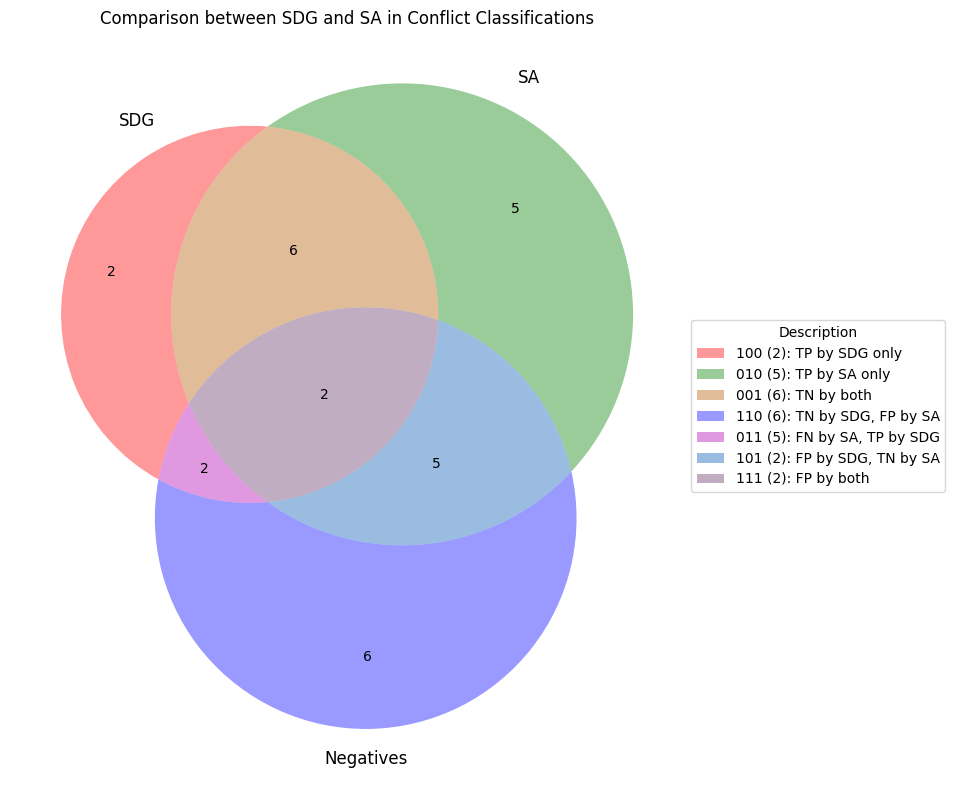

In [26]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

venn_data = {
    '100': 2,  # TP by SDG only
    '010': 5,  # TP by SA only
    '001': 6,  # TN by both
    '110': 6,  # TN by SDG, FP by SA
    '011': 5,  # FN by SA, TP by SDG
    '101': 2,  # FP by SDG, TN by SA
    '111': 2,  # FP by both
}

fig, ax = plt.subplots(figsize=(10, 8))

venn = venn3(subsets=venn_data, set_labels=('SDG', 'SA', 'Negatives'), ax=ax)

legend_labels = [
    "100 (2): TP by SDG only",
    "010 (5): TP by SA only",
    "001 (6): TN by both",
    "110 (6): TN by SDG, FP by SA",
    "011 (5): FN by SA, TP by SDG",
    "101 (2): FP by SDG, TN by SA",
    "111 (2): FP by both"
]

plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Description")

plt.title("Comparison between SDG and SA in Conflict Classifications")

plt.tight_layout()
plt.show()
